# PROJECTE IDENTIFICACIÓ DE VEU PER 4 PERSONES

### Introducció

Este proyecto tiene como objetivo diseñar e implementar un sistema de reconocimiento e identificación de voz para cuatro personas específicas. El sistema utilizará técnicas de procesamiento de señales de audio y aprendizaje automático para reconocer y distinguir las voces de las personas autorizadas.
El proceso de desarrollo constará de varias etapas clave. En primer lugar, se recopilarán muestras de voz de las cuatro personas de interés, abarcando una variedad de palabras y frases relevantes para el contexto de uso previsto. Estas muestras de voz se preprocesarán para extraer características acústicas relevantes, como tono, intensidad y frecuencia.
A continuación, se utilizarán algoritmos de aprendizaje automático para entrenar un modelo de reconocimiento de voz. Durante el entrenamiento, el modelo aprenderá a asociar las características acústicas de las muestras de voz con las identidades de las cuatro personas.
Una vez entrenado el modelo, se procederá a la fase de evaluación y ajuste fino. Se probará el sistema utilizando conjuntos de datos adicionales que no se utilizaron durante el entrenamiento, con el fin de evaluar su precisión y rendimiento en la identificación de las cuatro personas. Se realizarán ajustes en el modelo según sea necesario para mejorar su capacidad de reconocimiento y reducir posibles errores.


### Datos


Recopilaremos muestras de voz de cada uno de los usuarios a identificar mediante el modelo, 50 audios del tipo "hola, qué tal?" para cada uno de los usuarios a identificar, adicionalmente añadiremos 100 muestras de audio de usuarios diferentes a identificar. Por lo tanto contaremos con un total 300 audios.

|  id |  id_mensaje | audio    |   id persona |
|-----------|-----------|-----------|-----------|
| int    (0 -> 299)     |  int (01 -> 50)  |  str (path)  |  int (0 -> 5)



### Procedimiento

A paritr de los audios generados individualmente, los convertiremos en espectogramas para así convertir audios en imágenes. Los espectogramas serán las características de cada usuario a identificar. 

#### Imports

In [18]:
%pip install scikit-image

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <Thread(Thread-17 (listen_microphone), stopped 123145554513920)>>
Traceback (most recent call last):
  File "/Users/albertceballos/3curso/VC/.conda/lib/python3.11/threading.py", line 1002, in _bootstrap
    self._bootstrap_inner()
  File "/Users/albertceballos/3curso/VC/.conda/lib/python3.11/threading.py", line 1047, in _bootstrap_inner
    self._invoke_excepthook(self)
  File "/Users/albertceballos/3curso/VC/.conda/lib/python3.11/threading.py", line 1359, in invoke_excepthook
    local_print("Exception in threading.excepthook:",
  File "/Users/albertceballos/3curso/VC/.conda/lib/python3.11/site-packages/ipykernel/iostream.py", line 604, in flush
    self.pub_thread.schedule(self._flush)
  File "/Users/albertceballos/3curso/VC/.conda/lib/python3.11/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "/Users/alber

Escuchando...Reconociendo...
No se entendió el audio.


Note: you may need to restart the kernel to use updated packages.


In [1]:
from pydub import AudioSegment
import time
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft
import numpy as np
import warnings

import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.optimizers import SGD, RMSprop # type: ignore

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from scipy.ndimage import gaussian_laplace
from scipy import ndimage

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import cv2
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import describe

import threading
import speech_recognition as sr
from pydub import AudioSegment
import io
import time
import queue

import joblib

warnings.filterwarnings("ignore")

2024-05-17 12:35:49.791364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Pasar a mp3 los audios

In [ ]:
def ajustar_duracion(audio, duracion_ms):
    """
    Ajusta la duración de un archivo de audio a una duración específica en milisegundos.
    """
    if len(audio) > duracion_ms:
        return audio[:duracion_ms]
    else:
        padding = AudioSegment.silent(duration=duracion_ms - len(audio))
        return audio + padding


In [ ]:
def convertiraudiosMP3():
    '''The function `convertiraudiosMP3` converts audio files in the 'Audios' directory to MP3 format and
    prints the time taken for loading and conversion.
        
    '''
    #Convertir audios a mp3
    files = os.listdir('Audios')
    for file in files:
        if file[-3:] == ('m4a' or 'mp4') :
            try:
                audio = AudioSegment.from_file('Audios\\' + file, format=file[-3:])
                audio.export('AudiosMp3\\' + file[:-4] + ".mp3", format="mp3")
            except:
                audio = AudioSegment.from_file('Audios/' + file, format=file[-3:])
                audio.export('AudiosMp3/' + file[:-4] + ".mp3", format="mp3")

    #Convertir ruidos a mp3
    files = os.listdir('Ruidos')
    for file in files:
        if file[-3:] == ('m4a' or 'mp4') :
            try:
                audio = AudioSegment.from_file('Ruidos\\' + file, format=file[-3:])
                audio.export('RuidosMp3\\' + file[:-4] + ".mp3", format="mp3")
            except:
                audio = AudioSegment.from_file('Ruidos/' + file, format=file[-3:])
                audio.export('RuidosMp3/' + file[:-4] + ".mp3", format="mp3")


    #Añadir ruido
    files = os.listdir('AudiosMp3')
    ruidos = os.listdir('RuidosMp3')
    audio_ruido = AudioSegment.empty()
    for ruido_file in ruidos:
        ruido = AudioSegment.from_file('RuidosMp3\\' + ruido_file, format="mp3")
        for file in files:
            audio = AudioSegment.from_file('AudiosMp3\\' + file, format="mp3")

            if audio.frame_rate != ruido.frame_rate:
                ruido = ruido.set_frame_rate(audio.frame_rate)

            ruido = ajustar_duracion(ruido, len(audio))
            audio_ruido = audio.overlay(ruido)
            audio_ruido.export('AudiosMp3\\' + file[:-4] + ruido_file[:-4] + ".mp3", format="mp3")
    

    t0 = time.time()
    audio = AudioSegment.from_file("prueba.m4a", format="m4a")
    print("Tiempo de carga: ", time.time() - t0)

    t0 = time.time()
    audio.export("archivo.mp3", format="mp3")
    print("Tiempo de conversión: ", time.time() - t0)

    print("Conversión completada.")

convertiraudiosMP3()

Tiempo de carga:  0.2895660400390625
Tiempo de conversión:  0.18048405647277832
Conversión completada.


#### Creación Dataset

In [2]:
def createDataset():
    '''The function creates a dataset from audio files in a directory, extracting message ID, audio file
    name, and person ID.
    
    Returns
    -------
        A DataFrame containing information about audio files in the 'AudiosMp3' directory. The DataFrame
    has columns 'Id_Mensaje', 'Audio', and 'Id_Persona'.
    
    '''
    
    if os.path.exists('AudiosMp3') == False:
        convertiraudiosMP3()

    filesMp3 = os.listdir('AudiosMp3')
    
    dict = {'Id_Mensaje': [], 'Audio': [], 'Id_Persona': []}
    for file in filesMp3:
        dict['Id_Mensaje'].append(int(file[:2]))
        dict['Audio'].append(file)
        if file[3:-4] == 'Gerard': 
            dict['Id_Persona'].append(0)
        elif file[3:-4] == 'Albert': 
            dict['Id_Persona'].append(1)
        elif file[3:-4] == 'Adria': 
            dict['Id_Persona'].append(2)
        elif file[3:-4] == 'Raul': 
            dict['Id_Persona'].append(3)
        elif file[3:-4] == 'MadreGerard':
            dict['Id_Persona'].append(4) 
        elif file[3:-4] == 'PadreGerard':
            dict['Id_Persona'].append(4)
        elif file[3:-4] == 'Jessi':
            dict['Id_Persona'].append(4)
            
    df = pd.DataFrame(dict)
    return df

df = createDataset()

#### Visualizar audios

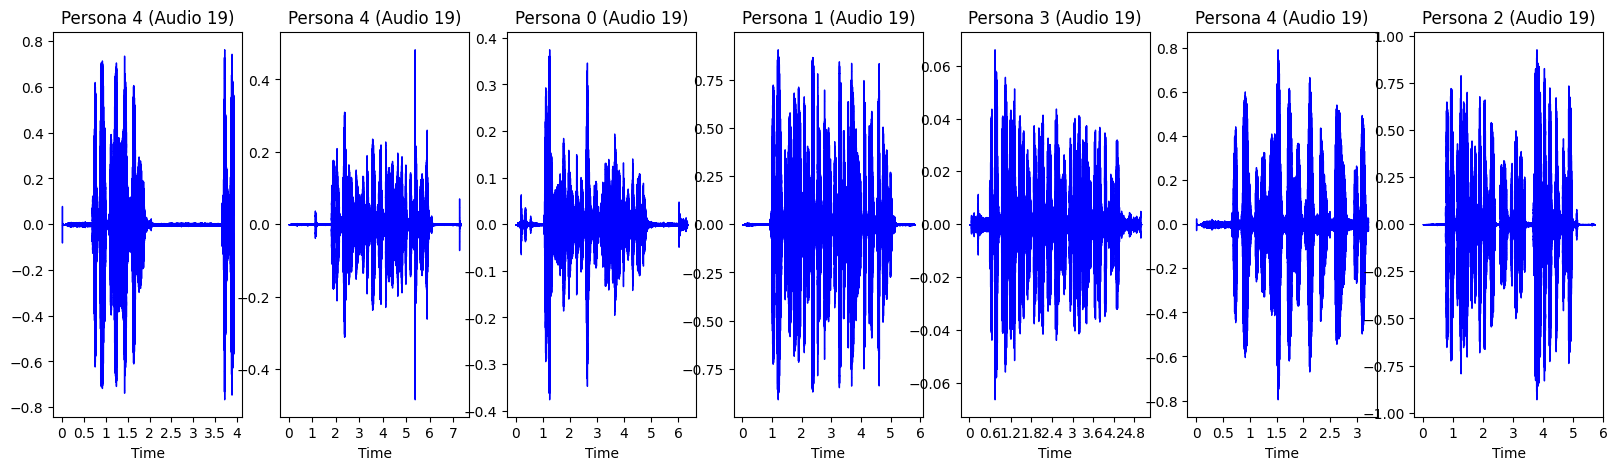

In [ ]:
def visualizeAudio(nAudio):
  '''The function `visualizeAudio` takes an audio ID as input, retrieves corresponding audio files from a
  DataFrame, and displays waveforms of the audio files in a subplot.
      
  Parameters
  ----------
  nAudio
  It looks like you have provided a code snippet for visualizing audio data from a DataFrame based on
  a specific audio ID. The `visualizeAudio` function takes an audio ID (`nAudio`) as input and then
  plots the waveforms of the corresponding audio files.
      
  '''
  audios = df[df['Id_Mensaje'] == nAudio]

  audios = audios.reset_index()
  fig, ax = plt.subplots(1, len(audios), figsize=(20, 5))
  i = 0
  for index, row in audios.iterrows():
        # Cargar el archivo de audio MP3
      try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
      except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
        
      y = lowPassFilter(y, sr, 3000)
      librosa.display.waveshow(y ,sr=sr, ax=ax[i], color="blue")
      ax[i].set_title('Persona ' + str(row['Id_Persona']) + ' (Audio ' + str(nAudio) + ')')
      i = i +1
  plt.show()

visualizeAudio(19)
    


In [ ]:
def fft_plot(y, sr, persona, nAudio, ax):
    '''The function `fft_plot` calculates the Fast Fourier Transform of an audio signal and plots the
    frequency spectrum.
    
    Parameters
    ----------
    y
        The parameter "y" in the function `fft_plot` is typically the input signal that you want to analyze
    using the Fast Fourier Transform (FFT). This signal is usually a time-domain audio signal
    represented as a one-dimensional array of amplitude values.
    sr
        The parameter `sr` in the `fft_plot` function represents the sampling rate of the audio signal `y`.
    It indicates how many samples of the signal are taken per second.
    persona
        It seems like you were about to ask for an explanation of the `persona` parameter in your
    `fft_plot` function. The `persona` parameter likely represents a specific person or entity
    associated with the audio data being analyzed. It could be used to differentiate between different
    individuals or sources of audio data when
    nAudio
        It seems like the explanation for the parameter `nAudio` is missing in the provided code snippet.
    Could you please provide more information or context about the `nAudio` parameter so that I can
    assist you better?
    ax
        The `ax` parameter in the `fft_plot` function is typically used to pass a Matplotlib Axes object,
    which represents a subplot where the FFT plot will be displayed. This allows you to plot the FFT
    graph on a specific subplot within a larger figure, giving you more control over the layout of
    
    '''
    n = len(y)
    T = 1/sr
    yf = np.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), int(n/2))
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    ax.grid()
    ax.set_title("Rang de Frequencies Persona " + str(persona) + " (Audio " + str(nAudio) +")")
    ax.set_xlabel("Frequencia")
    ax.set_ylabel("Magnitud")
    c = yf[:n//2]

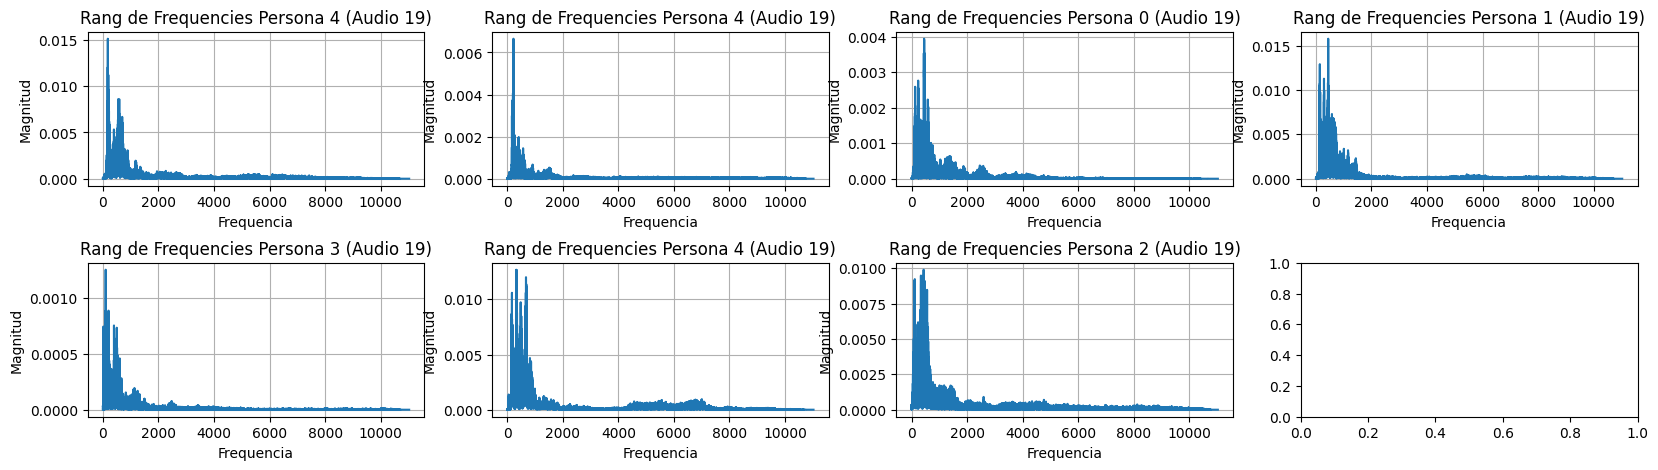

In [ ]:
def visualizeFFT(nAudio):
  '''The function `visualizeFFT` takes an audio ID as input, retrieves corresponding audio files, loads
  them, and plots their Fast Fourier Transform (FFT) using matplotlib and librosa.
        
  Parameters
  ----------
  nAudio
  It looks like the `visualizeFFT` function is designed to visualize the Fast Fourier Transform (FFT)
  of audio files. The `nAudio` parameter seems to represent the ID of the audio message you want to
  visualize.
    
  '''
  audios = df[df['Id_Mensaje'] == nAudio]
  audios = audios.reset_index()
  fig, ax = plt.subplots(2, int(len(audios)/2) + 1, figsize=(20, 5))
  i = 0
  j = 0
  for index, row in audios.iterrows():
        # Cargar el archivo de audio MP3
      try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
      except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
      fft_plot(y, sr, row['Id_Persona'], nAudio, ax[i, j])
      j = j + 1
      if j == int(len(audios)/2) + 1:
          j = 0
          i = i + 1
  plt.subplots_adjust(hspace=0.5)  # Ajustar el espacio vertical entre subgráficos
          
visualizeFFT(19)

#### Familiarització amb espectogrames

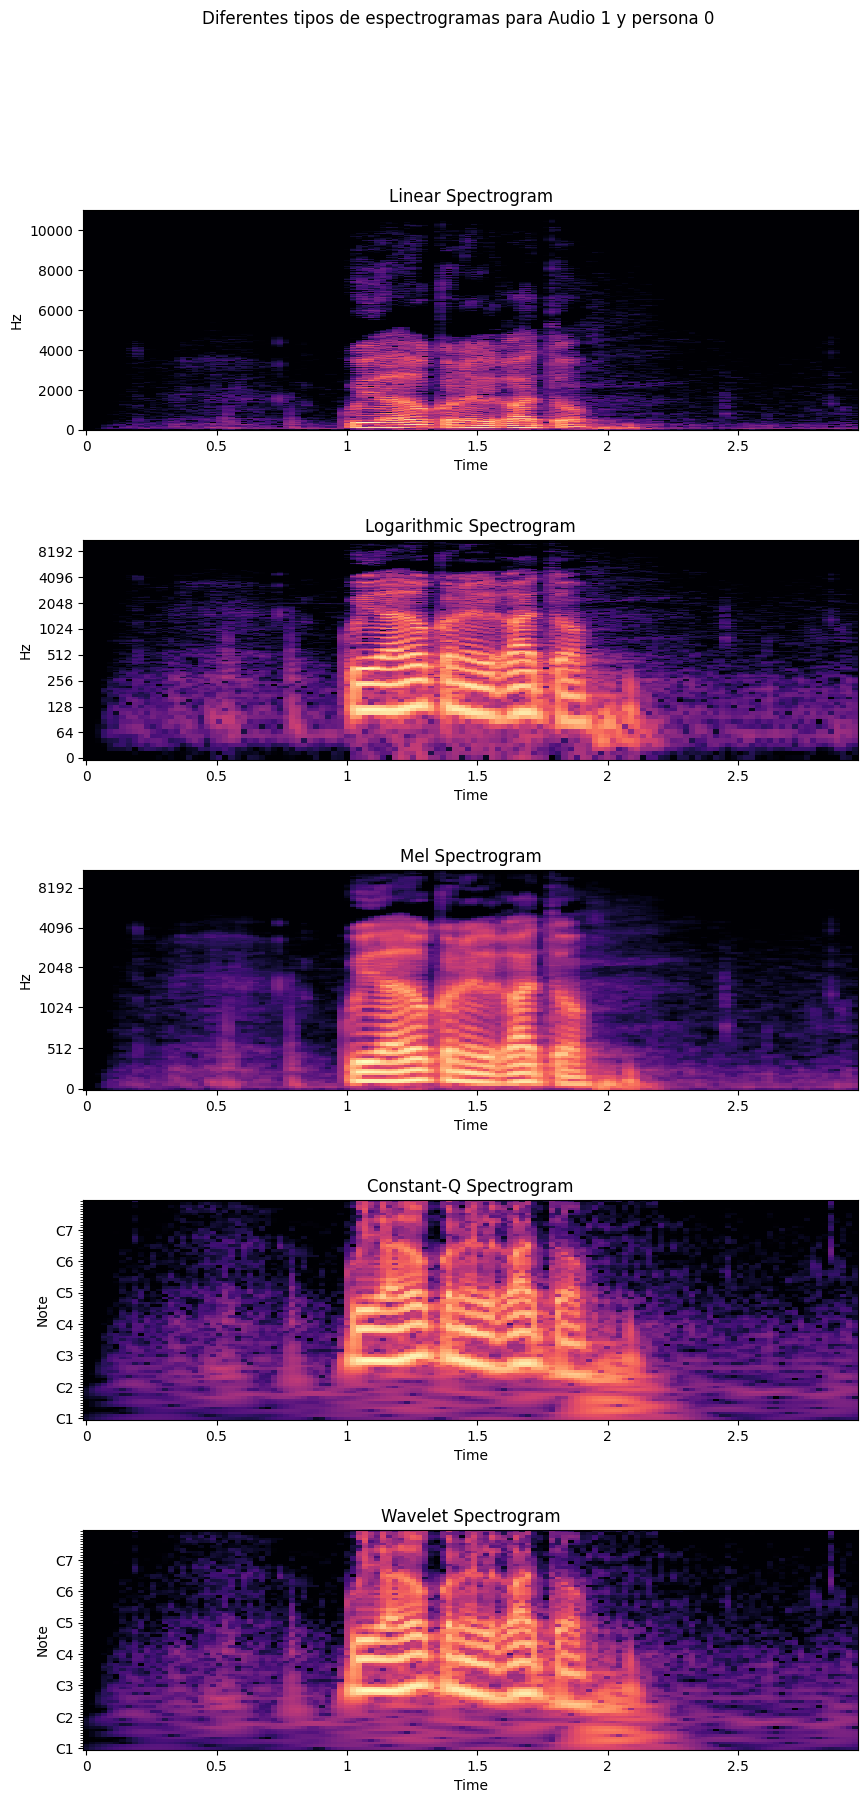

In [8]:
def visualzeSpectograms(nAudio):
    '''The function `visualzeSpectograms` generates and displays different types of spectrograms for a
    given audio file and person ID.
    
    Parameters
    ----------
    nAudio
        The function `visualzeSpectograms(nAudio)` is designed to visualize different types of spectrograms
    for a given audio file. The parameter `nAudio` represents the ID of the audio file for which you
    want to generate and display the spectrograms.
    
    '''
    
    fig, axs = plt.subplots(5, 1, figsize=(10, 20))

    audios = df[df['Id_Mensaje'] == nAudio]
    audios = audios.reset_index()

    audio = audios.iloc[0]
    try:
        y, sr = librosa.load(f"AudiosMp3\\{audio['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{audio['Audio']}")
    
    
    
    
    linear_spec = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(linear_spec, ref=np.max), ax=axs[0], sr=sr, x_axis='time', y_axis='linear')
    axs[0].set_title('Linear Spectrogram')

    log_spec = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(log_spec, ref=np.max), ax=axs[1], sr=sr, x_axis='time', y_axis='log')
    axs[1].set_title('Logarithmic Spectrogram')

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), ax=axs[2], sr=sr, x_axis='time', y_axis='mel')
    axs[2].set_title('Mel Spectrogram')

    cqt_spec = np.abs(librosa.cqt(y, sr=sr))
    librosa.display.specshow(librosa.amplitude_to_db(cqt_spec, ref=np.max), ax=axs[3], sr=sr, x_axis='time', y_axis='cqt_note')
    axs[3].set_title('Constant-Q Spectrogram')

    wavelet_spec = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C1')))
    librosa.display.specshow(librosa.amplitude_to_db(wavelet_spec, ref=np.max), ax=axs[4], sr=sr, x_axis='time', y_axis='cqt_note')
    axs[4].set_title('Wavelet Spectrogram')

    fig.suptitle('Diferentes tipos de espectrogramas para Audio ' + str(nAudio) + ' y persona ' + str(audio['Id_Persona']))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
     
visualzeSpectograms(1)

In [10]:
def removeSilence(audio, silence_threshold = 0.05):
    '''The `removeSilence` function removes silent segments from an audio signal based on a specified
    silence threshold.
    
    Parameters
    ----------
    audio
        The `removeSilence` function you provided is designed to remove segments of silence from an audio
    signal based on a specified silence threshold. The function takes two parameters:
    silence_threshold
        The `silence_threshold` parameter in the `removeSilence` function represents the minimum amplitude
    value below which a segment of audio is considered as silence. Any audio samples with absolute
    values less than this threshold are identified as silence and removed from the audio signal. By
    adjusting this threshold, you can control
    
    Returns
    -------
        The function `removeSilence` returns the audio signal with silence segments removed based on the
    specified silence threshold.
    
    '''
    # Encontrar los índices de los segmentos de silencio
    silence_indices = np.where(np.abs(audio) < silence_threshold)[0]

    # Crear una máscara para mantener los segmentos que no son de silencio
    mask = np.ones_like(audio, dtype=bool)
    mask[silence_indices] = False

    # Aplicar la máscara al audio para eliminar los segmentos de silencio
    audio_sin_silencio = audio[mask]

    if audio_sin_silencio.size == 0:
        return audio
    return audio_sin_silencio


In [11]:
def lowPassFilter(audio, sr, cutoff_freq = 3000):
    '''The function `lowPassFilter` applies a low-pass filter to an audio signal in the frequency domain to
    remove high-frequency components above a specified cutoff frequency.
    
    Parameters
    ----------
    audio
        The `audio` parameter is the input audio signal that you want to filter using a low-pass filter. It
    is typically represented as a one-dimensional array of audio samples.
    sr
        The `sr` parameter in the `lowPassFilter` function stands for the sampling rate of the audio
    signal. It represents the number of samples taken per second when the audio signal was recorded or
    processed. The sampling rate is typically measured in Hertz (Hz).
    cutoff_freq
        The `cutoff_freq` parameter in the `lowPassFilter` function represents the frequency at which you
    want to filter out higher frequencies from the audio signal. Frequencies above the `cutoff_freq`
    will be attenuated or removed from the signal, effectively creating a low-pass filter that allows
    only
    
    Returns
    -------
        The function `lowPassFilter` returns the filtered audio signal in the time domain after applying a
    low-pass filter in the frequency domain.
    
    '''
    y_fft = np.fft.fft(audio)

    freqs = np.fft.fftfreq(len(audio), 1 / sr)
    lowpass_filter = np.abs(freqs) <= cutoff_freq

    # Aplicar el filtro pasa bajos multiplicando la señal en el dominio de la frecuencia por el filtro
    y_fft_filtered = y_fft * lowpass_filter

    # Aplicar la Transformada Inversa de Fourier para obtener la señal filtrada en el dominio del tiempo
    y_filtered = np.real(np.fft.ifft(y_fft_filtered))
    
    return y_filtered


In [12]:
def gaussian_laplacian_kernel(size, sigma):
    """Genera un kernel de convolución para la laplaciana de Gaussiana."""
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            kernel[i, j] = (1/(2*np.pi*sigma**4)) * ((i - center)**2 + (j - center)**2 - 2*sigma**2) * np.exp(-((i - center)**2 + (j - center)**2)/(2*sigma**2))
    return kernel

def convolve2d(image, kernel):
    """Realiza la convolución 2D."""
    m, n = kernel.shape
    y, x = image.shape
    y = y - m + 1
    x = x - m + 1
    result = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            result[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return result

def smooth_image(image, sigma):
    """Suaviza una imagen utilizando un filtro Gaussiano."""
    kernel_size = int(6 * sigma)
    if kernel_size % 2 == 0:
        kernel_size += 1
    kernel = gaussian_laplacian_kernel(kernel_size, sigma)
    smoothed_image = convolve2d(image, kernel)
    return smoothed_image

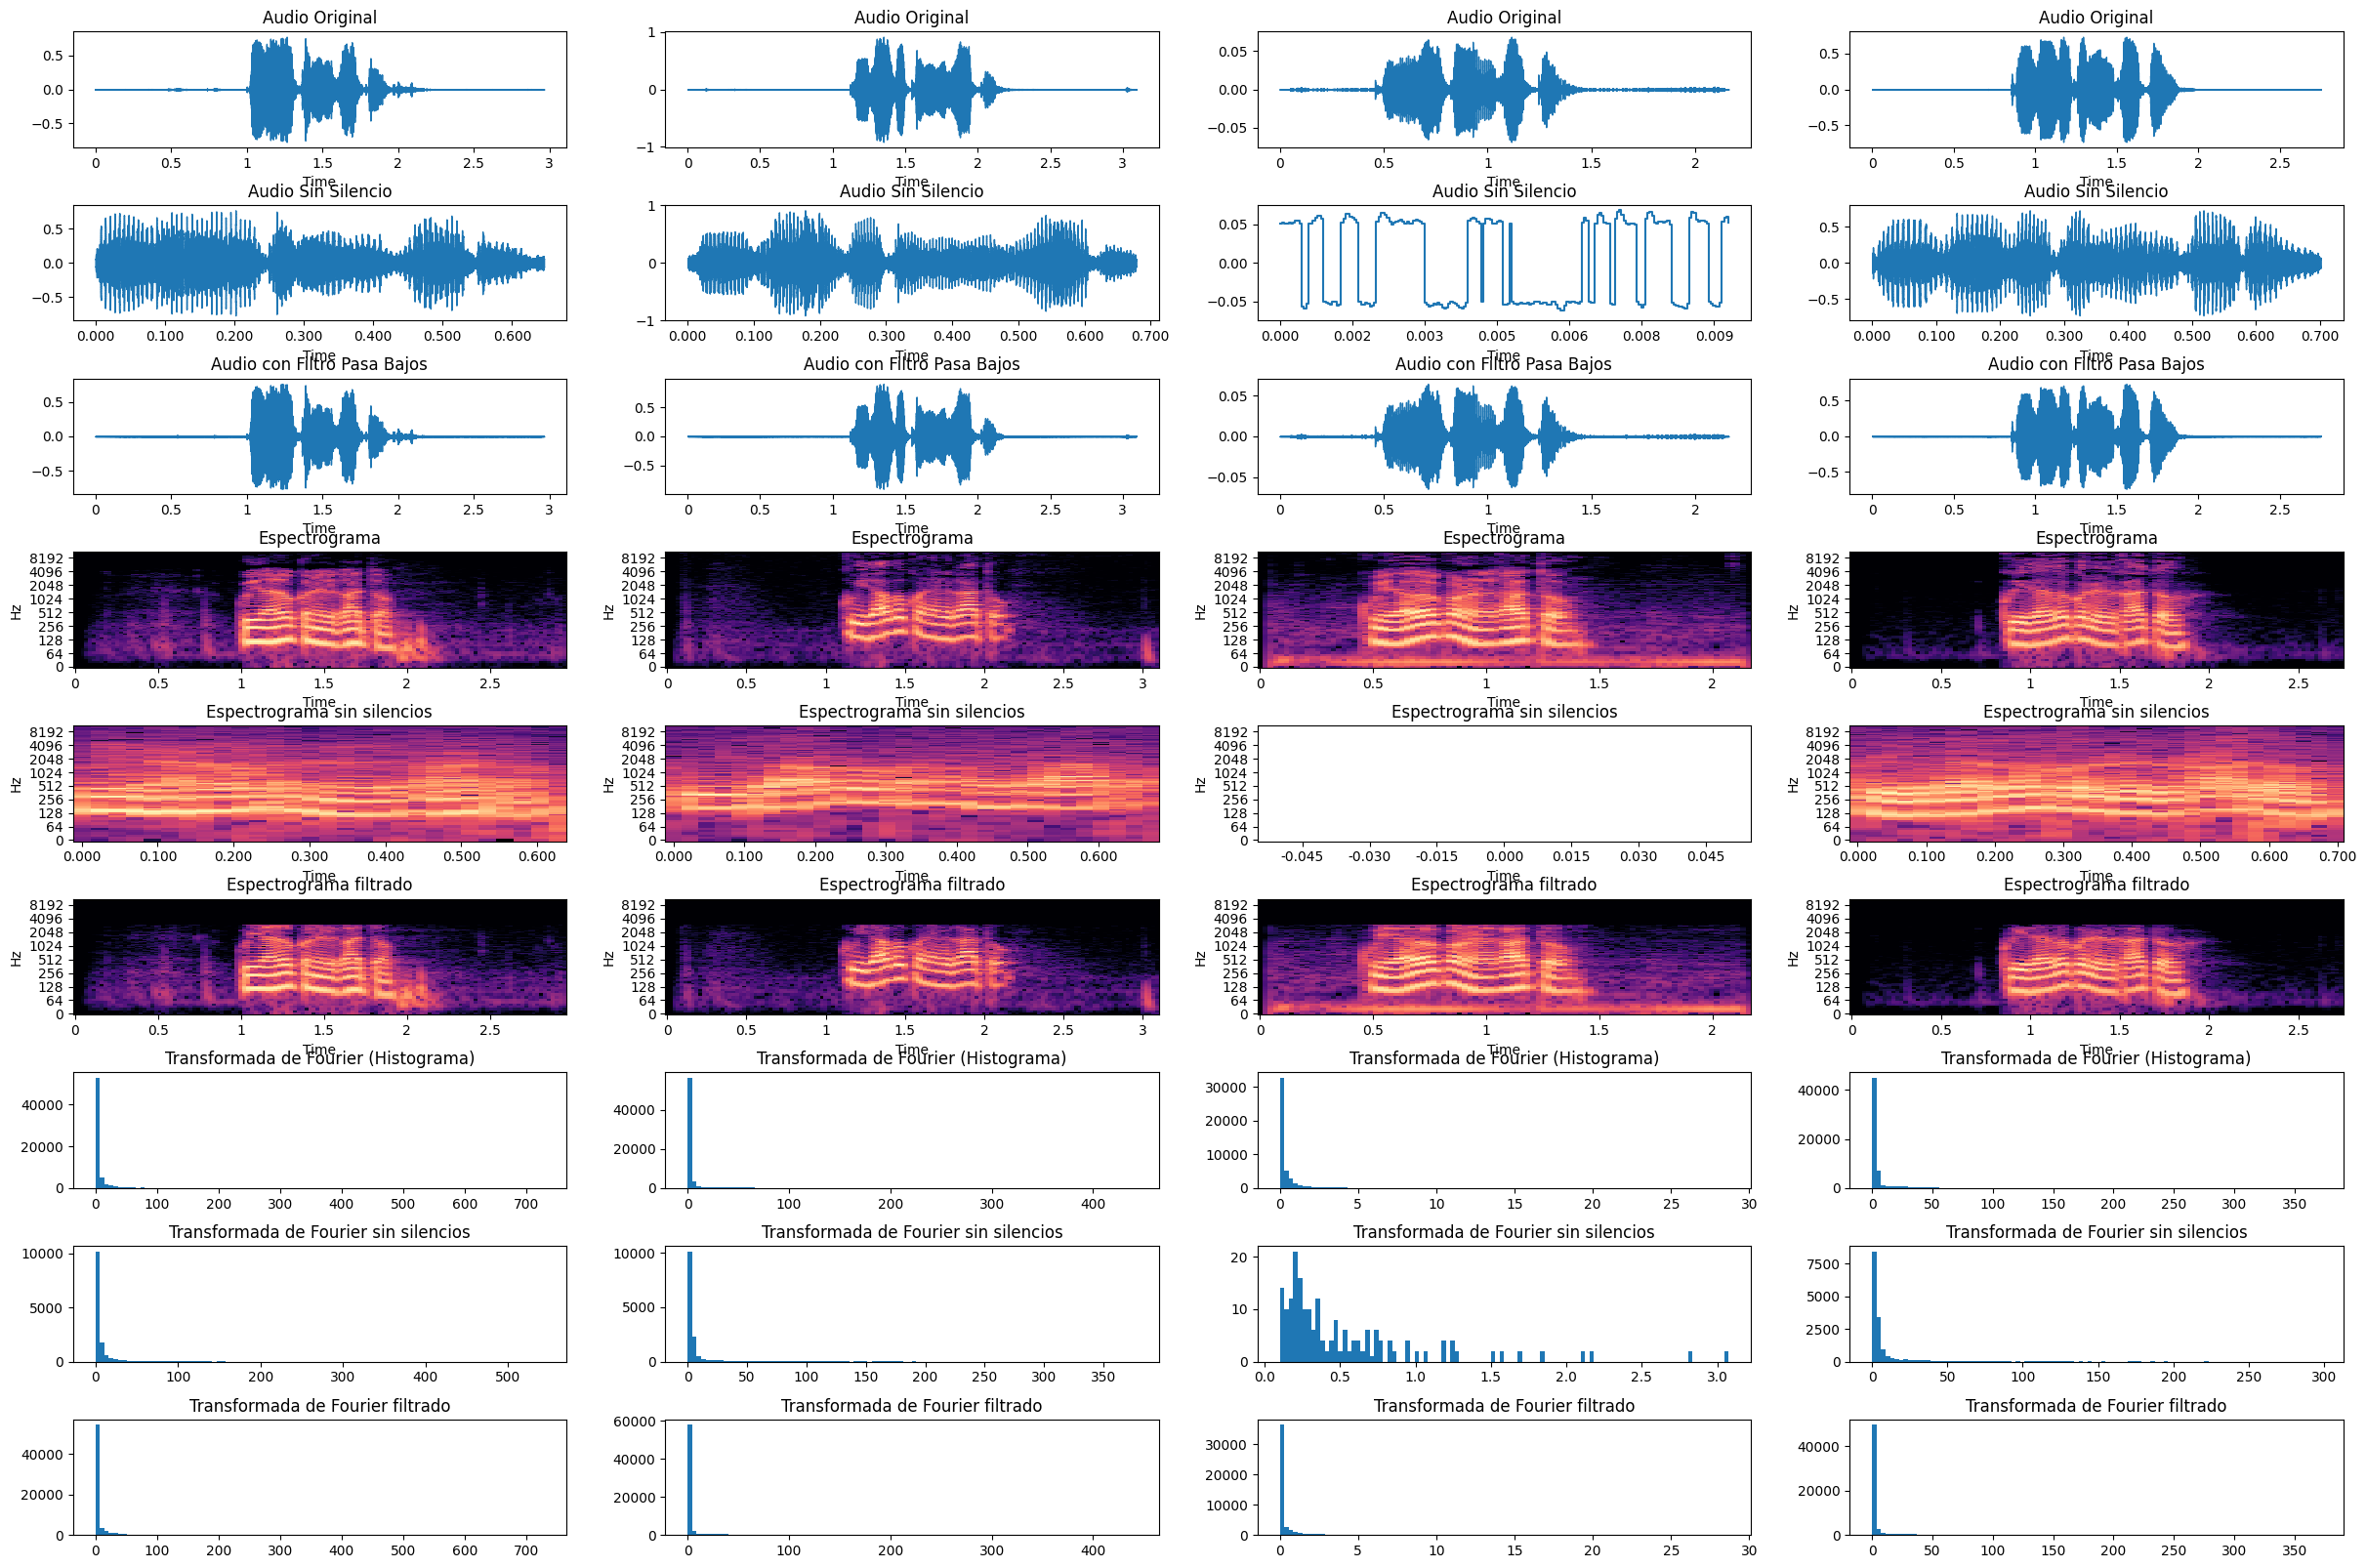

In [13]:
def visualizeAll( nAudio):
    '''The function `visualize_audio` takes an audio ID, loads the audio file, applies various audio
    processing techniques, and visualizes the original audio, filtered audio, spectrograms, and Fourier
    transforms.
    
    Parameters
    ----------
    nAudio
        It seems like the `visualize_audio` function is designed to visualize different aspects of audio
    data stored in a DataFrame based on the provided `nAudio` identifier. The function loads audio
    files, processes them, and displays various visualizations such as waveforms, spectrograms, and
    Fourier transforms.
    
    '''
    audios = df[df['Id_Mensaje'] == nAudio]
    audios = audios.reset_index()
    
    fig, ax = plt.subplots(9, 4, figsize=(30, 20))
    plt.subplots_adjust(hspace=0.5)

    for index, row in audios.iterrows():
        try:
            # Cargar el archivo de audio MP3
            y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
        except:
            y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")

        # Visualizar el audio original
        librosa.display.waveshow(y, sr=sr, ax=ax[0, index])
        ax[0, index].set_title('Audio Original')
        
        # Eliminar silencios
        y_sin_silencio = removeSilence(y)
        librosa.display.waveshow(y_sin_silencio, sr=sr, ax=ax[1, index])
        ax[1, index].set_title('Audio Sin Silencio')

        # Aplicar filtro pasa bajos
        y_filtrado = lowPassFilter(y, sr)
        librosa.display.waveshow(y_filtrado, sr=sr, ax=ax[2, index])
        ax[2, index].set_title('Audio con Filtro Pasa Bajos')

        # Espectrograma
        D = np.abs(librosa.stft(y))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, ax=ax[3, index], x_axis='time', y_axis='log')
        ax[3, index].set_title('Espectrograma')
        
        # Espectrograma sin silencio
        D = np.abs(librosa.stft(y_sin_silencio))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, ax=ax[4, index], x_axis='time', y_axis='log')
        ax[4, index].set_title('Espectrograma sin silencios')
        
        # Espectrograma filtrado
        D = np.abs(librosa.stft(y_filtrado))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, ax=ax[5, index], x_axis='time', y_axis='log')
        ax[5, index].set_title('Espectrograma filtrado')
        

        # Transformada de Fourier (en forma de histograma)
        y_fft = np.fft.fft(y)
        ax[6, index].hist(np.abs(y_fft), bins=100)
        ax[6, index].set_title('Transformada de Fourier (Histograma)')
        
        # Transformada de Fourier sin silencios
        y_fft = np.fft.fft(y_sin_silencio)
        ax[7, index].hist(np.abs(y_fft), bins=100)
        ax[7, index].set_title('Transformada de Fourier sin silencios')
        
        # Transformada de Fourier filtrado
        y_fft = np.fft.fft(y_filtrado)
        ax[8, index].hist(np.abs(y_fft), bins=100)
        ax[8, index].set_title('Transformada de Fourier filtrado')
        
    
    plt.show()

visualizeAll(1)

## Modelos de identificación de voz

###  El primer model (Logistic regression amb 15 característiques extretes de librosa.feature)

In [3]:
def extract_features(y, sr):
    '''The function `extract_features` calculates various audio features from a given audio signal using
    the librosa library and returns them as a list.
    
    Parameters
    ----------
    y
        The parameter `y` in the `extract_features` function represents the audio time series. It is the
    audio signal as a one-dimensional NumPy array.
    sr
        The `sr` parameter in the `extract_features` function stands for the sampling rate of the audio
    signal. It represents the number of samples of audio carried per second, typically measured in Hz
    (Hertz). It is an important parameter in audio processing as it determines the quality and fidelity
    of the audio
    
    Returns
    -------
        The function `extract_features` returns a list of mean values of various audio features extracted
    using Librosa library functions. The features include chroma_stft, spectral centroid, spectral
    bandwidth, spectral rolloff, zero crossing rate, spectral flatness, and root mean square (RMS)
    energy.
    
    '''
    features = []
    features.append(np.mean(librosa.feature.chroma_stft(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    features.append(np.mean(librosa.feature.spectral_flatness(y=y)))
    features.append(np.mean(librosa.feature.rms(y=y)))
  
    
    return features


In [4]:
def smooth_audio(y, sigma):
    '''The function smooths audio data by applying convolution with a Gaussian Laplacian kernel.
    
    Parameters
    ----------
    y
        The parameter `y` in the `smooth_audio` function represents the audio signal that you want to
    smooth out. It could be a one-dimensional array or a list containing the audio samples. The function
    `smooth_audio` applies Gaussian Laplacian convolution to the input audio signal `y` with a
    sigma
        The `sigma` parameter in the `smooth_audio` function represents the standard deviation of the
    Gaussian kernel used for smoothing the audio signal `y`. A larger `sigma` value will result in a
    smoother output signal with more pronounced blurring effects.
    
    Returns
    -------
        The function `smooth_audio` returns the audio signal `smoothed_y` after applying convolution with
    the Gaussian Laplacian kernel with a specified sigma value.
    
    '''
    # Aplicar la convolución con el kernel de la laplaciana de Gaussiana
    smoothed_y = gaussian_laplace(y, sigma=sigma)
    return smoothed_y

In [5]:
def compute_row(row, smoothAudio = False, silence = False, filter = False):
    '''The function `compute_row` loads an audio file, extracts features from it, and returns the features
    along with the corresponding person ID.
    
    Parameters
    ----------
    row
        The `row` parameter in the `compute_row` function represents a single row of data from a DataFrame.
    In this case, it seems like the DataFrame `df` contains information about audio files, and each row
    corresponds to a specific audio file entry.
    
    Returns
    -------
        The code is returning a DataFrame `data` that contains the features extracted from audio files in
    the DataFrame `df`. Each row in the DataFrame `data` contains the features extracted from an audio
    file along with the corresponding 'Id_Persona' from the original DataFrame `df`.
    
    '''
    try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    # Replace this with your feature extraction code

    if silence:
        try: 
            y = removeSilence(y)
        except: 
            print("Error al eliminar silencios")
    
    if smoothAudio: y = smooth_audio(y, 5)

    if filter: y = lowPassFilter(y, sr)

    features = extract_features(y, sr)
    
    return features, row['Id_Persona']




In [6]:
def unzipData(data):
    '''The `unzipData` function takes a list of tuples, separates the elements into two arrays, and returns
    them.
    
    Parameters
    ----------
    data
        The `data` parameter is expected to be a list of tuples where each tuple contains two elements. The
    first element should be the input data (X) and the second element should be the corresponding target
    data (y).
    
    Returns
    -------
        The `unzipData` function returns two arrays, `X` and `y`, after unzipping the input `data` and
    converting them into numpy arrays.
    
    '''
    X, y = zip(*data)
    X = np.array(list(X))
    y =np.array(list(y))
    return X, y



In [15]:
def backtestFeaturesModel():
    '''The `backtest` function performs a machine learning backtesting process on a given DataFrame,
    testing different models with various preprocessing techniques and storing the results in a
    DataFrame.
    
    Parameters
    ----------
    df
        The `backtest` function you provided seems to be performing a machine learning model evaluation
    process on a given DataFrame `df`. It iterates over different combinations of preprocessing methods
    and models to evaluate their performance using accuracy as the metric.
    
    Returns
    -------
        The function `backtest(df)` returns a pandas DataFrame containing the results of testing different
    machine learning models (SVM, Logistic Regression, Random Forest) with different preprocessing
    methods (No preprocessing, StandardScaler) on the input data `df`. The DataFrame includes columns
    for the model used, the preprocessing method applied, and the accuracy score achieved by each model
    during testing.
    
    '''
    results = []


    for filterAudio in [True, False]:
        for silenceAudio in [True, False]:
            data = df.apply(lambda row: compute_row(row, filter=filterAudio, silence=silenceAudio), axis=1)
                
            X, y = unzipData(data)
                    
            sc = StandardScaler()        # Guardar el modelo y el normalizador
            X = StandardScaler().fit_transform(X)
            joblib.dump(sc, f'./modelos/scaler_featureModel_filter_{str(filterAudio)}_silence_{str(silenceAudio)}.pkl')
    
            for model, modelName in [ (SVC(), 'svc'),  (LogisticRegression(), 'lr'), (RandomForestClassifier(), 'rf')]:

                print(f"Model {str(model)} - filter: {str(filterAudio)} - silence: {str(silenceAudio)}")

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

                t0 = time.time()
                model.fit(X_train, y_train)
                        
                joblib.dump(model, f'./modelos/{modelName}_featureModel_filter_{str(filterAudio)}_silence_{str(silenceAudio)}.pkl')
    
                t1 = time.time() - t0
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                results.append({
                    'Model': modelName,
                    'silence': str(silenceAudio),
                    'filter': str(filterAudio),   
                    'Accuracy': accuracy,
                    'time' : t1,
                                    
                })
                    

    return pd.DataFrame(results)



In [16]:
res = backtestFeaturesModel()
res = res.sort_values(by='Accuracy', ascending=False)

Model SVC() - filter: True - silence: True
Model LogisticRegression() - filter: True - silence: True
Model RandomForestClassifier() - filter: True - silence: True
Model SVC() - filter: True - silence: False
Model LogisticRegression() - filter: True - silence: False
Model RandomForestClassifier() - filter: True - silence: False
Model SVC() - filter: False - silence: True
Model LogisticRegression() - filter: False - silence: True
Model RandomForestClassifier() - filter: False - silence: True
Model SVC() - filter: False - silence: False
Model LogisticRegression() - filter: False - silence: False
Model RandomForestClassifier() - filter: False - silence: False


In [17]:
res

,Model,silence,filter,Accuracy,time
9,svc,False,False,0.907407,0.003565
10,lr,False,False,0.907407,0.006921
11,rf,False,False,0.870370,0.159777
0,svc,True,True,0.759259,0.009034
8,rf,True,False,0.759259,0.164074
4,lr,False,True,0.740741,0.006013
5,rf,False,True,0.740741,0.172471
6,svc,True,False,0.740741,0.004192
7,lr,True,False,0.740741,0.008247
2,rf,True,True,0.722222,0.167075


### Segon model utilitzant espectogrames y una petita xarxa neuronal

In [18]:
def spec(y, sr, spec = 'wavelet'):
    '''This Python function generates different types of spectrograms based on the specified type.
    
    Parameters
    ----------
    y
        The function `spec` you provided seems to be a spectrogram generator that can produce different
    types of spectrograms based on the specified `spec` parameter. However, there are a couple of issues
    in the code:
    sr
        The `sr` parameter in the `spec` function stands for the sampling rate of the audio signal. It
    represents the number of samples of audio carried per second, typically measured in Hz (Hertz).
    spec, optional
        The `spec` function you provided seems to be a spectrogram generator that can produce different
    types of spectrograms based on the `spec` parameter provided. The spectrogram types it supports are
    'wavelet', 'linear', 'log', 'mel', and 'cqt'.
    
    Returns
    -------
        the spectrogram based on the specified type of spectrogram calculation method (wavelet, linear,
    log, mel, or cqt).
    
    '''
    

    if spec == 'linear'  : spectogram = np.abs(librosa.stft(y))

    elif spec == 'log' : spectogram = np.abs(librosa.stft(y))
    
    elif spec == 'mel' : spectogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    elif spec == 'cqt' : spectogram = np.abs(librosa.cqt(y, sr=sr))
    
    elif spec == 'wavelet' : spectogram = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C1')))
    
    else: return None
    return spectogram

In [19]:
def extrapolate_audio(y, sr, desired_duration):
    '''The function extrapolates an audio signal to a desired duration by repeating or truncating the
    original signal accordingly.
    
    Parameters
    ----------
    y
        The parameter `y` in the `extrapolate_audio` function represents the audio signal as a
    one-dimensional NumPy array.
    sr
        The `sr` parameter in the `extrapolate_audio` function stands for the sampling rate of the audio
    signal. It represents the number of samples of audio carried per second, typically measured in Hz
    (Hertz). This parameter is used to determine the duration of the audio signal and to ensure that
    desired_duration
        The `desired_duration` parameter in the `extrapolate_audio` function represents the target duration
    in seconds that you want the audio to be extrapolated or truncated to. This parameter is used to
    determine whether the input audio `y` should be repeated or truncated to match the desired duration.
    
    Returns
    -------
        The function `extrapolate_audio` returns extrapolated audio data that either repeats the input
    audio until the desired duration is reached or truncates the input audio to the desired duration.
    The function also returns the sampling rate `sr` of the audio.
    
    '''
    audio_duration = librosa.get_duration(y=y, sr=sr)
    if audio_duration < desired_duration:
        # Repeat the audio until desired duration is reached
        repetitions = int(desired_duration / audio_duration) + 1
        extrapolated_audio = np.tile(y, repetitions)[:desired_duration * sr]
    else:
        # Truncate the audio to the desired duration
        extrapolated_audio = y[:desired_duration * sr]
    return extrapolated_audio, sr


In [50]:
def compute_rowSpec(row, smoothSpec= False, filter = False, silence = False):
    '''This function loads an audio file, processes it to generate a spectrogram image, and optionally
    applies smoothing to the image.
    
    Parameters
    ----------
    row
        The `row` parameter in the `compute_rowSpec` function seems to be a dictionary-like object that
    contains information about an audio file, such as the file name ('Audio') and the person's ID
    ('Id_Persona'). This function loads the audio file specified in the 'Audio' field
    smooth, optional
        The `smooth` parameter in the `compute_rowSpec` function is a boolean parameter that determines
    whether to apply smoothing to the spectrogram image generated. If `smooth` is set to `True`, the
    function will apply smoothing to the spectrogram image using a specified parameter value. If
    `smooth`
    
    Returns
    -------
        The function `compute_rowSpec` returns an image representation of the audio file specified in the
    input row, along with the 'Id_Persona' value from the row. If the `smooth` parameter is set to True,
    the image is smoothed before being returned.
    
    '''
    try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
        
    
    if silence: y = removeSilence(y)

    
    y, sr = extrapolate_audio(y, sr, 6)
    
    
    if filter: y = lowPassFilter(y, sr)
        
    image = spec(y, sr, spec='wavelet')
    if smoothSpec: image = smooth_image(image, 1.5)
    
    return image, row['Id_Persona']



In [51]:
def normalize_image(image):
    '''The `normalize_image` function flattens and normalizes an input image using StandardScaler.
    
    Parameters
    ----------
    image
        It looks like the code you provided is a function to normalize an image using StandardScaler from
    scikit-learn. However, you didn't provide the actual image data that needs to be normalized. If you
    provide me with the image data, I can help you normalize it using the given function. Just
    
    Returns
    -------
        The function `normalize_image` returns the normalized version of the input image after flattening
    and applying StandardScaler to it.
    
    '''
    
    flattened_image = image.flatten().reshape(-1, 1)
    
    sc = StandardScaler()
    
    
    normalized_image = StandardScaler().fit_transform(flattened_image).reshape(image.shape)
    
    return normalized_image, sc

In [52]:
def backtesSpecModel(df):
    '''The function `backtesSpecModel` trains a convolutional neural network model on image data with
    different preprocessing options and returns the results in a DataFrame.
    
    Parameters
    ----------
    df
        The function `backtesSpecModel` takes a DataFrame `df` as input and performs a series of operations
    on it. Here is a breakdown of the steps within the function:
    
    Returns
    -------
        The function `backtesSpecModel(df)` returns a pandas DataFrame containing the results of training
    and evaluating a Convolutional Neural Network (CNN) model on the input data `df`. The DataFrame
    includes columns for the model type ('cnn'), preprocessing method (normalized or not), smooth
    parameter (True or False), accuracy of the model, and the time taken for training.
    
    '''
    results = []

    for filter in [True, False]:
        for silence in [ True, False]:
            data = df.apply(lambda row: compute_rowSpec(row, filter=True, silence = False), axis=1)
            X, y = unzipData(data)
            for normalize in [True, False]: 
                if normalize:
                    X, sc = normalize_image(X)
                
                joblib.dump(sc, f'./modelos/scaler_specModel_filter_{str(filter)}_silence_{str(silence)}_normalize_{str(normalize)}.pkl')
                
                print(f"Iteración para {normalize, filter, silence, 'cnn'} ")
                
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


                input_shape = X_train.shape[1:]
                print(X_train.shape)
                model = models.Sequential([
                    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(input_shape[0], input_shape[1], 1), padding='valid'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.Flatten(),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(5, activation='softmax')
                ])
                model.compile(optimizer= 'adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

                model.fit(X_train, y_train, epochs=8, batch_size=32)


                joblib.dump(model, f'./modelos/cnn_specModel_filter_{str(filter)}_silence_{str(silence)}_normalize_{str(normalize)}.pkl')
                y_pred = model.predict(X_test)
                
                y_pred = np.argmax(y_pred, axis=1)
                
                accuracy = accuracy_score(y_test, y_pred)

                results.append({
                        'Model': 'cnn',
                        'Preprocessing': normalize,
                        'filter': filter,
                        'silence': silence,
                        'Accuracy': accuracy,
                        
                })

    return pd.DataFrame(results)
res = backtesSpecModel(df)


Iteración para (True, True, True, 'cnn') 
(213, 84, 259)
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 564ms/step - accuracy: 0.3633 - loss: 1.6716
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 616ms/step - accuracy: 0.8326 - loss: 0.5270
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - accuracy: 0.9784 - loss: 0.1512
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 627ms/step - accuracy: 0.9744 - loss: 0.0707
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - accuracy: 0.9988 - loss: 0.0216
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step - accuracy: 0.9988 - loss: 0.0098
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step - accuracy: 0.9974 - loss: 0.0130
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 562ms/step - accuracy: 0.9951 - loss: 0.0199
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Iteración para (False, True, True, 'cnn') 
(213, 84, 259)
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 599ms/step - accuracy: 0.3555 - loss: 1.4126
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step - accuracy: 0.9250 - loss: 0.3783
Epoch 3/8
7/7 ━

In [53]:
res = res.sort_values(by='Accuracy', ascending=False)
res

,Model,Preprocessing,filter,silence,Accuracy
3,cnn,False,True,False,0.981481
4,cnn,True,False,True,0.962963
0,cnn,True,True,True,0.944444
1,cnn,False,True,True,0.925926
6,cnn,True,False,False,0.925926
7,cnn,False,False,False,0.925926
2,cnn,True,True,False,0.907407
5,cnn,False,False,True,0.870370


### Tercer model simple (Rangs de frequencies)

In [ ]:
def slice_and_sum_frequencies(yf, range_size=50):
    '''This Python function slices a given array of frequencies into smaller ranges and calculates the sum
    of absolute values within each range.
    
    Parameters
    ----------
    yf
        The `yf` parameter seems to be a frequency array that is being sliced and processed in the
    `slice_and_sum_frequencies` function. The function slices the first 3000 elements of `yf` and then
    calculates the sum of absolute values of frequencies in each range of size `range
    range_size, optional
        The `range_size` parameter in the `slice_and_sum_frequencies` function determines the size of each
    frequency range that will be considered when summing the frequencies. By default, it is set to 50,
    meaning that the frequencies will be divided into ranges of size 50 for summation.
    
    Returns
    -------
        The function `slice_and_sum_frequencies` returns an array `summed_ranges` which contains the sum of
    absolute values of frequencies in each range of size `range_size` within the input array `yf` (up to
    the first 3000 elements of `yf`).
    
    '''
    yf = yf[:3000]
    num_freqs = 3000
    num_ranges = num_freqs // range_size
    
    summed_ranges = np.zeros(num_ranges)
    
    for i in range(num_ranges):
        freqs_in_range = yf[i * range_size: (i + 1) * range_size]
        summed_ranges[i] = np.sum(np.abs(freqs_in_range))
    
    return summed_ranges

### Primer ejemplo con frequencias agrupadas en rangos de 50

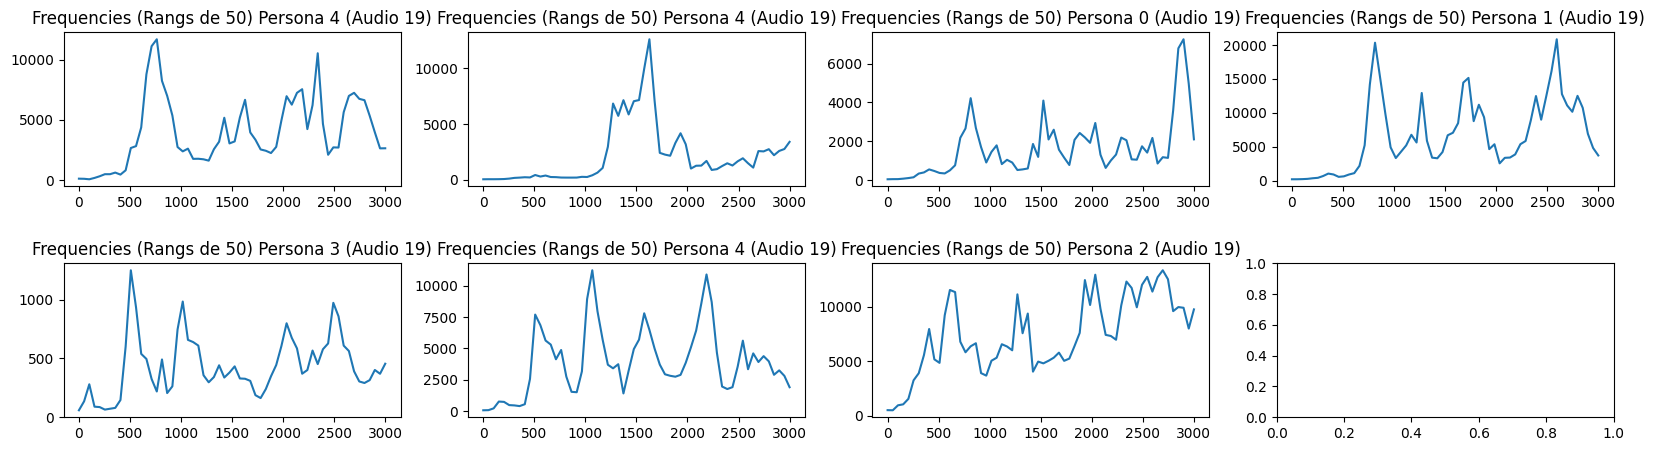

In [ ]:
def visualizeFrequencies(nAudio):
    '''The function `visualizeFrequencies` takes an audio ID, loads corresponding audio files, calculates
    FFT, and plots frequency ranges for each audio file.
    
    Parameters
    ----------
    nAudio
        It looks like the `visualizeFrequencies` function you provided is meant to visualize the
    frequencies of audio data. The function takes an argument `nAudio`, which seems to represent the
    audio ID for which you want to visualize the frequencies.
    
    '''
    rangs = np.linspace(0.0, 3000, 60)
    
    
    #yf = np.fft.fft(y)
    #xf = np.linspace(0.0, 1.0/(2.0*T), int(n/2))
    #ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))

    audios = df[df['Id_Mensaje'] == nAudio]
    audios = audios.reset_index()
    fig, ax = plt.subplots(2, int(len(audios)/2) + 1, figsize=(20, 5))
    i = 0
    j = 0
    for index, row in audios.iterrows():
      # Cargar el archivo de audio MP3
        try:
          y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
        except:
          y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")

        y = lowPassFilter(y, sr)
        
        yf = np.fft.fft(y)
        freq_ranges = slice_and_sum_frequencies(yf)
        ax[i, j].plot(rangs,freq_ranges)
        ax[i, j].set_title("Frequencies (Rangs de 50) Persona " + str(row['Id_Persona']) + " (Audio " + str(nAudio) +")")
        j = j + 1
        if j == int(len(audios)/2) + 1:
            j = 0
            i = i + 1
    plt.subplots_adjust(hspace=0.5)

visualizeFrequencies(19)



#### Creación del dataset

In [ ]:
def createDfFreq():
    '''The `createDfFreq` function processes audio files in a DataFrame to extract frequency ranges and
    adds them as new columns to the DataFrame.
    
    Returns
    -------
        The function `createDfFreq()` returns a pandas DataFrame that combines the original DataFrame `df`
    with additional columns representing frequency ranges extracted from audio files. The additional
    columns are named `freq_0`, `freq_1`, ..., `freq_n` where `n` is the number of frequency ranges
    extracted from the audio files.
    
    '''
    matriu_freq = []

    for audio_file in df['Audio']:
        try:
            y, sr = librosa.load(f"AudiosMp3\\{audio_file}")
        except:
            y, sr = librosa.load(f"AudiosMp3/{audio_file}")

        y = lowPassFilter(y, sr)
        
        yf = np.fft.fft(y)
        freq_ranges = slice_and_sum_frequencies(yf)
        matriu_freq.append(freq_ranges)

    return pd.concat([df, pd.DataFrame(matriu_freq, columns=[f'freq_{i}' for i in range(len(matriu_freq[0]))])], axis=1)

df_freq = createDfFreq()
df_freq

,Id_Mensaje,Audio,Id_Persona,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,...,freq_50,freq_51,freq_52,freq_53,freq_54,freq_55,freq_56,freq_57,freq_58,freq_59
0,33,33_Albert.mp3,1,131.206988,169.475871,364.171997,429.462183,367.967962,594.686893,547.535234,...,1692.285321,2275.526538,2444.150252,2385.155621,2608.927486,1621.699528,1472.387269,2174.972420,1706.096256,2265.526711
1,4,04_Albert.mp3,1,163.318973,254.693003,332.474084,267.396443,348.965759,1205.904313,1758.647864,...,406.071023,420.388415,528.634311,555.411889,808.102809,582.201506,677.324254,506.399260,454.762069,435.540419
2,29,29_Adria.mp3,2,97.928847,255.536177,749.578451,994.682164,1055.069892,1391.099306,1859.682202,...,599.014278,470.704182,424.674779,269.306275,490.516136,887.584486,886.483068,807.849844,1112.834930,903.187303
3,48,48_Jessi.mp3,4,40.286516,90.435394,372.499632,171.503589,347.384762,249.213970,101.674220,...,650.873085,777.910590,1292.100861,1783.976369,897.573865,998.951331,805.975080,589.690794,373.703720,652.885750
4,47,47_Adria.mp3,2,89.417378,125.637510,294.273266,178.538799,1382.427787,891.730609,2169.149428,...,3031.253860,992.906221,931.385702,2472.359718,1387.284364,2487.234601,2370.016309,1641.752255,840.045407,1354.821274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,21,21_Gerard.mp3,0,63.275331,102.743544,185.512135,383.629611,435.351054,2701.616582,4189.608681,...,190.883662,194.235375,284.537220,573.480371,618.758397,518.066707,418.928071,360.983109,464.526565,621.705523
263,43,43_PadreGerard.mp3,4,132.797806,182.415193,267.025555,3485.680229,7911.277451,7845.997315,2483.523835,...,199.231308,213.715743,235.310137,325.033228,250.349286,193.270626,203.937695,183.005234,120.542189,117.917712
264,14,14_Adria.mp3,2,289.378754,277.115505,1048.033916,1881.255088,1889.795567,3746.501353,4242.660404,...,1174.576562,1259.094379,1593.703293,2031.820454,1688.157022,1051.243391,1151.663539,1369.102843,1263.373394,975.430875
265,36,36_Raul.mp3,3,96.430944,48.760025,32.725385,482.705697,533.337548,438.298813,710.722376,...,104.954322,101.470281,60.712363,153.445374,83.525473,52.540614,46.466187,46.636447,40.808891,27.959551


In [ ]:
X = df_freq.drop(columns=['Id_Mensaje', 'Audio', 'Id_Persona'])
y = df_freq['Id_Persona']

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((213, 60), (54, 60), (213,), (54,))

In [ ]:
lr = LogisticRegression(max_iter=1000, C=0.3)
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.57      0.40      0.47        10
           2       0.67      0.60      0.63        10
           3       1.00      1.00      1.00        10
           4       0.67      0.86      0.75        14

    accuracy                           0.70        54
   macro avg       0.70      0.69      0.69        54
weighted avg       0.70      0.70      0.69        54



#### Comprovar cual es el rango optimo en el que separar las frequencias

Text(0, 0.5, 'Accuracy')

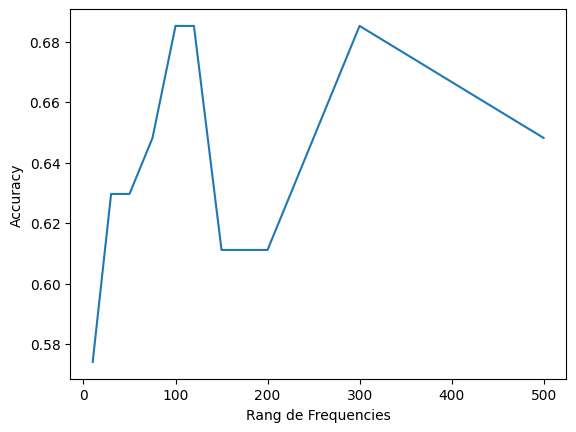

In [ ]:
def backtestRang(model='lr', smooth = True):
  '''The function `backtest_rang` performs a range of frequency analysis on audio data using logistic
  regression or random forest classifier and returns the accuracy scores and classification reports
  for different frequency ranges.
  
  Parameters
  ----------
  model, optional
    The `backtest_rang` function you provided performs a backtesting procedure for a given model
  (either logistic regression or random forest) over different frequency ranges. It calculates the
  accuracy scores and classification reports for each frequency range and returns the results.
  
  Returns
  -------
    The function `backtest_rang` returns three lists: `rangs` which contains the frequency ranges
  tested, `accuracies` which contains the accuracy scores for each frequency range, and `reports`
  which contains the classification reports for each frequency range.
  
  '''
  
  rangs = [10, 30, 50, 75, 100, 120, 150, 200, 300, 500]
  yfs = []
  accuracies = []
  reports = []

  for index, row in df.iterrows(): # Cargar el archivo de audio MP3
          try:
            y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
          except:
            y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
            
          if smooth : y = smooth_audio(y, 3)
          
          yfs.append(np.fft.fft(y))


  for rang in rangs:
      matriu_freq = []
      for yf in yfs:
          freq_ranges = slice_and_sum_frequencies(yf, rang)
          matriu_freq.append(freq_ranges)

      df_freq = df.copy()
      for i in range(len(matriu_freq[0])):
          df_freq[f'freq_{i}'] = [matriu_freq[j][i] for j in range(len(matriu_freq))]

      X = df_freq.drop(columns=['Id_Mensaje', 'Audio', 'Id_Persona'])
      y = df_freq['Id_Persona']
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
      X_train.shape, X_test.shape, y_train.shape, y_test.shape
      
      if model == 'lr':
        m = LogisticRegression(max_iter=1000)

      elif model == 'rf':
        m = RandomForestClassifier()
        
      model = m.fit(X_train, y_train)
      y_pred = model.predict(X_test)

        
      accuracies.append(accuracy_score(y_test, y_pred))
      reports.append(classification_report(y_test, y_pred))
  return rangs, accuracies, reports
    
rangs, accuracies, reports = backtestRang('lr', smooth = True)
plt.plot(rangs, accuracies)
plt.xlabel('Rang de Frequencies')
plt.ylabel('Accuracy')

In [ ]:
millor_index = np.argmax(accuracies)
print("Millor rang de frequencies: ", rangs[millor_index])
print("---------------------------------")
print("---------------------------------")
print(reports[millor_index])

Millor rang de frequencies:  100
---------------------------------
---------------------------------
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.57      0.40      0.47        10
           2       0.58      0.70      0.64        10
           3       0.91      1.00      0.95        10
           4       0.67      0.71      0.69        14

    accuracy                           0.69        54
   macro avg       0.68      0.68      0.68        54
weighted avg       0.68      0.69      0.68        54



Millor rang de frequencies:  150
---------------------------------
---------------------------------
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.64      0.90      0.75        10
           2       0.78      0.70      0.74        10
           3       0.91      1.00      0.95        10
           4       0.88      0.50      0.64        14

    accuracy                           0.78        54
   macro avg       0.79      0.80      0.78        54
weighted avg       0.80      0.78      0.77        54



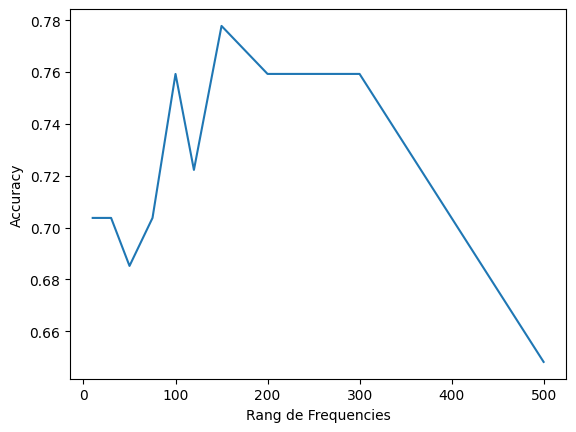

In [ ]:
rangs, accuracies, reports = backtestRang('rf')
plt.plot(rangs, accuracies)
plt.xlabel('Rang de Frequencies')
plt.ylabel('Accuracy')
millor_index = np.argmax(accuracies)
print("Millor rang de frequencies: ", rangs[millor_index])
print("---------------------------------")
print("---------------------------------")
print(reports[millor_index])

## Modelo mediante windowing o ventana deslizante para los espectogramas

In [28]:
def windowing(image, max_size, despl=0):
    '''The function `windowing` creates a matrix of windows from an input image by rearranging its columns.
    
    Parameters
    ----------
    image
        The `image` parameter is a 2D numpy array representing an image. Each element in the array
    corresponds to a pixel value in the image.
    max_size
        The `max_size` parameter in the `windowing` function represents the maximum size of the window
    matrix that will be created. This parameter determines the number of rows in the window matrix,
    while the number of columns will be the same as the number of columns in the input `image` matrix.
    
    Returns
    -------
        A matrix of windows with the same number of rows as the maximum size provided and the same number
    of columns as the input image. Each column of the matrix corresponds to a window extracted from the
    input image.
    
    '''
    
    if despl == 0 : windows = np.zeros((max_size, image.shape[0]))  # Crear matriz de ventanas con el mismo número de columnas que la imagen
    else: windows = np.zeros((max_size, image.shape[0], despl))
    for i in np.arange(0, image.shape[1]):
        if i + despl >= image.shape[1]:
            break
        if despl == 0: windows[i, :] = image[: , i]
        else: windows[ i, :, :] = image[: , i :i + despl]
    return windows


In [29]:
def compute_rowSpecWindowing(row, specType='mel', despl=0, smoothSpec = False, filter = False, silence = False):
    '''The function `compute_rowSpecWindowing` loads an audio file, processes it by removing silence and
    smoothing, generates a spectrogram image, and then applies windowing to create smaller segments
    along with corresponding labels.
    
    Parameters
    ----------
    row
        The `compute_rowSpecWindowing` function takes a row of data as input and processes the audio file
    specified in the row to generate spectrogram windows. Here is a breakdown of the parameters used in
    the function:
    clean, optional
        The `clean` parameter in the `compute_rowSpecWindowing` function is used to determine whether to
    remove silence from the beginning and end of the audio signal before processing it. If `clean=True`,
    the function will apply `librosa.effects.trim(y)` to remove the silence. If `
    smoothAudio, optional
        The `smoothAudio` parameter in the `compute_rowSpecWindowing` function is used to determine whether
    to apply smoothing to the audio signal before generating the spectrogram. If `smoothAudio` is set to
    `True`, the function will call a `smooth_audio` function with a smoothing factor of
    smoothSpec, optional
        The `smoothSpec` parameter in the `compute_rowSpecWindowing` function is used to determine whether
    to apply smoothing to the spectrogram image generated from the audio data. If `smoothSpec` is set to
    `True`, then the spectrogram image will be smoothed using the `smooth_image`
    
    Returns
    -------
        The code snippet is defining a function `compute_rowSpecWindowing` that processes audio data from a
    DataFrame row. It loads an audio file, trims silence if specified, applies smoothing to the audio
    and spectrogram if specified, generates a spectrogram image, and then performs windowing on the
    spectrogram image. Finally, it creates a numpy array `y` with the 'Id_Persona
    
    '''
    try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    

    if silence : y = removeSilence(y)    
    
    
    if filter: y = lowPassFilter(y, sr)



    image = spec(y, sr, spec=specType)
        
    if smoothSpec : image = smooth_image(image, 1.5)
    
    windows = windowing(image, 320, despl = despl)
    y = np.array([row['Id_Persona'] for i in range(320)])
    
    return windows, y

In [35]:
def backTestWindowing():
    '''The function `backTestWindowing` evaluates different machine learning models using various
    spectrogram types and returns classification reports for each model and spectrogram type.
    
    Parameters
    ----------
    smoothAudio, optional
        The `smoothAudio` parameter in the `backTestWindowing` function is a boolean parameter that
    determines whether audio data should be smoothed before processing. If `smoothAudio` is set to
    `True`, the audio data will undergo a smoothing process before further analysis. If set to `False`,
    the
    smoothSpec, optional
        The `smoothSpec` parameter in the `backTestWindowing` function controls whether to apply smoothing
    to the audio spectrogram data before processing it further. If `smoothSpec` is set to `True`, it
    indicates that you want to apply some form of smoothing to the spectrogram data. This
    
    Returns
    -------
        The function `backTestWindowing` is returning a dictionary `classification_reports` containing
    classification reports for different models and spectrogram types. Each model is evaluated with
    different spectrogram types ('linear', 'log', 'mel', 'cqt', 'wavelet'). The classification reports
    include metrics such as precision, recall, F1-score, and support for each class.
    
    '''

    models = {
        "RandomForest": RandomForestClassifier(),
        #"GradientBoosting": GradientBoostingClassifier(),
        #"XGBoost": XGBClassifier(),
        #"LightGBM": LGBMClassifier(),
    }
    
    results = []


    classification_reports = {}
    for model_name, model in models.items():
        classification_reports[model_name] = {}
            
        for filter in [True, False]:
            for silence in [True, False]:
                print(f"Evaluating {model_name} with {filter, silence} ...")

                data = df.apply(lambda row: compute_rowSpecWindowing(row, specType='mel',despl=0,  filter=filter, silence=silence), axis=1)

                X, y = unzipData(data)

                X = np.reshape(X, (X.shape[0] * X.shape[1], X.shape[2]))
                y = np.reshape(y, (y.shape[0] * y.shape[1]))

                y = y[np.mean(X, axis=1) != 0]
                X = X[np.mean(X, axis=1) != 0]

                sc =StandardScaler()

                X = sc.fit_transform(X)

                joblib.dump(sc, f'./modelos/windowing/scaler_windowing_{model_name}_filter_{str(filter)}_silence_{str(silence)}.pkl')

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

                model.fit(X_train, y_train)
            
                joblib.dump(sc, f'./modelos/windowing/rf_windowing_{model_name}_filter_{str(filter)}_silence_{str(silence)}.pkl')

                y_pred = model.predict(X_test)
                report = accuracy_score(y_test, y_pred)
                
                results.append({
                        'Model': 'rf',
                        'filter': filter,
                        'silence': silence,
                        'Accuracy': report,
                        
                })

    return pd.DataFrame(results)

In [36]:
reports = backTestWindowing()

Evaluating RandomForest with (True, True) ...
Evaluating RandomForest with (True, False) ...
Evaluating RandomForest with (False, True) ...
Evaluating RandomForest with (False, False) ...


In [34]:
reports = reports.sort_values(by='Accuracy', ascending=False)
reports

,Model,filter,silence,Accuracy
3,rf,False,False,0.909259
1,rf,True,False,0.845278
2,rf,False,True,0.772324
0,rf,True,True,0.732106


In [71]:
import speech_recognition as sr
import numpy as np
import joblib

# Load your pre-trained model and scaler
model = joblib.load('./modelos/specsModel/cnn_specModel_filter_True_silence_True_normalize_True.pkl')

# Initialize the microphone and recognizer
microphone = sr.Microphone()
recognizer = sr.Recognizer()

with microphone as source:
    print("Listening...")
    print("Calibrating microphone for ambient noise...")
    recognizer.adjust_for_ambient_noise(source, duration=5)
    
    print("Calibrando para ruido ambiente...")    
    #noise = recognizer.listen(source, phrase_time_limit=5)
    #noise = noise.get_raw_data(convert_rate=noise.sample_rate, convert_width=noise.sample_width)
    #noise = np.frombuffer(noise, dtype=np.int16)
    
    while True:
        print("Listening...")
        audio = recognizer.listen(source, phrase_time_limit=5)
        
        try:
            print("Recognizing...")
            text = recognizer.recognize_google(audio_data=audio, language='es-ES')
            print(f"Recognized: {text}")
            if 'siéntate' in text:
                raw_data = audio.get_raw_data(convert_rate=audio.sample_rate, convert_width=audio.sample_width)
                audio_np = np.frombuffer(raw_data, dtype=np.float32)
        
                # Preprocess the audio data
                audio_np = removeSilence(audio_np)
                
                audio_np = lowPassFilter(audio_np, audio.sample_rate)
                
                audio_np, _ = extrapolate_audio(audio_np, audio.sample_rate, 6)
                audio_np = np.nan_to_num(audio_np, nan=0.0, posinf=0.0, neginf=0.0)

                # Generate the spectrogram
                image = spec(audio_np, audio.sample_rate, spec='mel')

                # Normalize and reshape the spectrogram
                image_flat = image.flatten().reshape(1, -1)
                normalized_image = StandardScaler().fit_transform(image_flat).reshape(image.shape)
                
                normalized_image = np.resize(normalized_image, (84, 259))
                
                normalized_image = np.expand_dims(normalized_image, axis=-1)  # New shape: (84, 259, 1)
                normalized_image = np.expand_dims(normalized_image, axis=0)   # New shape: (1, 84, 259, 1)

                # Ensure the batch size is 32
                
                batch_size = 32
                batch_images = np.zeros((batch_size, 84, 259, 1))
                batch_images[0] = normalized_image  # Add your normalized image to the batch
                
                # Predict using the model
                y_pred = model.predict(batch_images)
                
                print(f"Predicted: {y_pred}")
                
        except sr.UnknownValueError:
            print("Could not understand audio")


'with microphone as source:\n    print("Listening...")\n    print("Calibrating microphone for ambient noise...")\n    recognizer.adjust_for_ambient_noise(source, duration=5)\n    \n    print("Calibrando para ruido ambiente...")    \n    #noise = recognizer.listen(source, phrase_time_limit=5)\n    #noise = noise.get_raw_data(convert_rate=noise.sample_rate, convert_width=noise.sample_width)\n    #noise = np.frombuffer(noise, dtype=np.int16)\n    \n    while True:\n        print("Listening...")\n        audio = recognizer.listen(source, phrase_time_limit=5)\n        \n        try:\n            print("Recognizing...")\n            text = recognizer.recognize_google(audio_data=audio, language=\'es-ES\')\n            print(f"Recognized: {text}")\n            if \'siéntate\' in text:\n                raw_data = audio.get_raw_data(convert_rate=audio.sample_rate, convert_width=audio.sample_width)\n                audio_np = np.frombuffer(raw_data, dtype=np.float32)\n        \n                # 

### Modelo complejo utilizando desplazamiento de ventana y correlaciones

#### Modelo no viable, poco optimizado muy lento 

In [ ]:
def compute_phase_correlation(spec1, spec2):
    spec1_fft = np.fft.fft2(spec1)
    spec2_fft = np.fft.fft2(spec2)

    cross_power_spectrum = spec1_fft * np.conj(spec2_fft)
    phase_correlation = np.abs(np.fft.ifft2(cross_power_spectrum))

    return phase_correlation

def predict(X_test, X_train, y_train):

    predictions = []
    for test_window in X_test:
        window_correlations = []
        for train_window in X_train:
            
            phase_correlation = compute_phase_correlation(test_window, train_window)
            window_correlations.append(np.max(phase_correlation))
            
        person_index = np.argmax(window_correlations)
        predictions.append(y_train[person_index])
    return np.array(predictions)


data = df.apply(lambda row: compute_rowSpecWindowing(row, specType='mel',despl=3, smoothAudio=True, smoothSpec=True, filter=True), axis=1)

X, y = unzipData(data)

X = np.reshape(X , (X.shape[0] * X.shape[1], X.shape[2], X.shape[3]))
y = np.reshape(y, (y.shape[0] * y.shape[1]))


y = y[np.mean(np.reshape(X, (X.shape[0], X.shape[1]* X.shape[2])), axis = 1) != 0]
X = X[np.mean(np.reshape(X, (X.shape[0], X.shape[1]* X.shape[2])), axis = 1) != 0]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



y_pred = predict(X_test, X_train, y_train)

print(classification_report(y_test, y_pred))

KeyboardInterrupt: 